## mountain ke arah google drive

In [26]:
import os
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## import library yang akan digunakan


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## menentukan lokasi penyimpanan dataset

In [28]:
base_dir = '/content/gdrive/MyDrive/test/'

!ls '/content/gdrive/MyDrive/test/'


bahan  latih  validasi


In [29]:
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validasi_dir = os.path.join(base_dir, 'validasi')

In [30]:
seratus_dir = os.path.join(bahan_dir, 'seratus/')
limapuluh_dir = os.path.join(bahan_dir, 'limapuluh/')

print("jumlah data train tiap kelas")
print("jumlah gambar uang seratus : ", len(os.listdir(seratus_dir)))
print("jumlah gambar uang limapuluh : ", len(os.listdir(limapuluh_dir)))

jumlah data train tiap kelas
jumlah gambar uang seratus :  227
jumlah gambar uang limapuluh :  171


In [31]:
train_seratus = os.path.join(train_dir, 'seratus/')
train_limapuluh = os.path.join(train_dir, 'limapuluh/')

validasi_seratus = os.path.join(validasi_dir, 'seratus/')
validasi_limapuluh = os.path.join(validasi_dir, 'limapuluh/')


## split data

In [32]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)


train_ratio = 0.9

source_00 = seratus_dir
train_00 = train_seratus
val_00 = validasi_seratus
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = limapuluh_dir
train_01 = train_limapuluh
val_01 = validasi_limapuluh
train_val_split(source_01, train_01, val_01, train_ratio)

In [33]:
print("jumlah gambar uang seratus : ", len(os.listdir(seratus_dir)))
print("jumlah gambar uang seratus (train) : ", len(os.listdir(train_seratus)))
print("jumlah gambar uang seratus (validasi) : ", len(os.listdir(validasi_seratus)))

jumlah gambar uang seratus :  227
jumlah gambar uang seratus (train) :  227
jumlah gambar uang seratus (validasi) :  151


## Augmentasi Data 

In [34]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

## pembagian kelas

In [35]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validasi_dir,
    target_size = (224,224),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 398 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


## membuat function callback yang fungsinya memberhentikan epoch training ketika akurasi mencapai 99%

In [36]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs =  {}):
    if(logs.get('accuracy') > 0.99):
      print("\nAkurasi mencapai 99%")
      self.model.stop_training = True

callbacks = myCallback()

## modeling

In [37]:
model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1, input_shape = (224, 224, 3)),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 401408)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 802818    
                                                                 
Total params: 803714 (3.07 MB)
Trainable params: 803714 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

## training data

In [39]:
history = model.fit(
    train_generator,
    epochs = 6,
    validation_data = val_generator,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/6
40/40 [==============================] - 52s 1s/step - loss: 6.9988 - accuracy: 0.5879 - val_loss: 0.6004 - val_accuracy: 0.8741
Epoch 2/6
40/40 [==============================] - 43s 1s/step - loss: 0.4083 - accuracy: 0.8819 - val_loss: 0.2211 - val_accuracy: 0.9593
Epoch 3/6
40/40 [==============================] - 48s 1s/step - loss: 0.1705 - accuracy: 0.9799 - val_loss: 0.1357 - val_accuracy: 0.9704
Epoch 4/6
40/40 [==============================] - 48s 1s/step - loss: 0.1300 - accuracy: 0.9623 - val_loss: 0.1086 - val_accuracy: 0.9963
Epoch 5/6
40/40 [==============================] - 49s 1s/step - loss: 0.1457 - accuracy: 0.9673 - val_loss: 0.0899 - val_accuracy: 0.9815
Epoch 6/6
40/40 [==============================] - 49s 1s/step - loss: 0.0701 - accuracy: 0.9874 - val_loss: 0.0579 - val_accuracy: 0.9926


## visualisasi hasil training

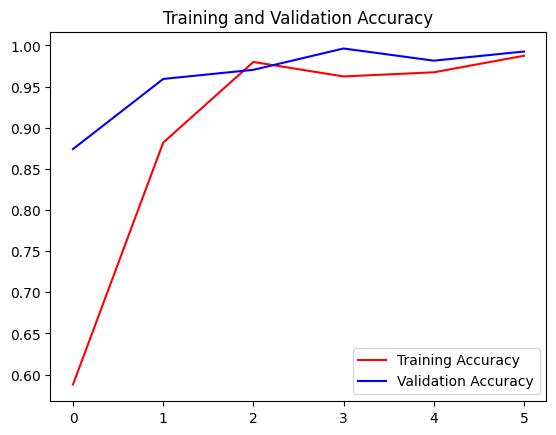

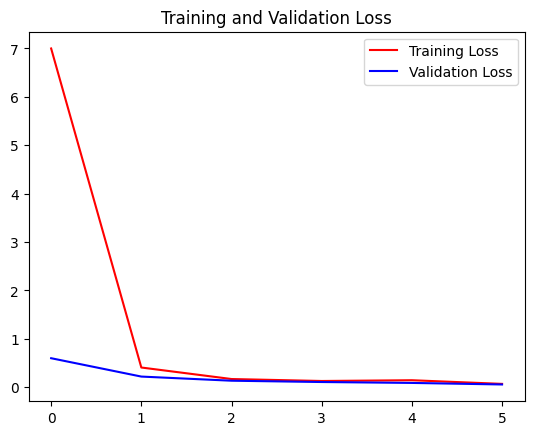

In [40]:
%matplotlib inline

import matplotlib.image as mpimg

acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc = 'best')
plt.show()

## evaluasi atau testing model yang telah dibuat

Saving Salinan UANG RUPOAH 100K  (4).jpeg to Salinan UANG RUPOAH 100K  (4) (14).jpeg
1/1 [==============================] - 0s 29ms/step
Salinan UANG RUPOAH 100K  (4) (14).jpeg
This Images Belongs To Class seratus


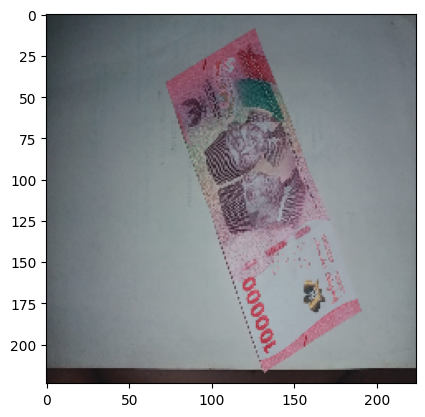

In [42]:
from keras.preprocessing import image
from google.colab import files

upload = files.upload()

for fn in upload.keys():

  path = fn
  img = image.load_img(path, target_size = (224, 224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1. :
      print('This Images Belongs To Class', class_list[j])
      break